# Bayesian Inference the Hard Way
- Based on Fundamentals of Bayesian Data Analysis in R on DataCamp
- Except programmed in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set_style ("whitegrid")
plt.style.use("seaborn-muted")

## Generative model for simulating datasets

In [2]:
def sim_data (s, p, i):
    """Binomial generative model that takes in a sample size (s),
    a number of iterations (i), and the expected success 
    rate (p), and returns a simulated 
    dataset of n size representing the success rate."""
    data = np.random.binomial(s, p, i)
    return data

In [3]:
p_success = 0.07 # Treatment is successful in 15% of patients
sample_size = 100 # number of patients
iterations = 100000

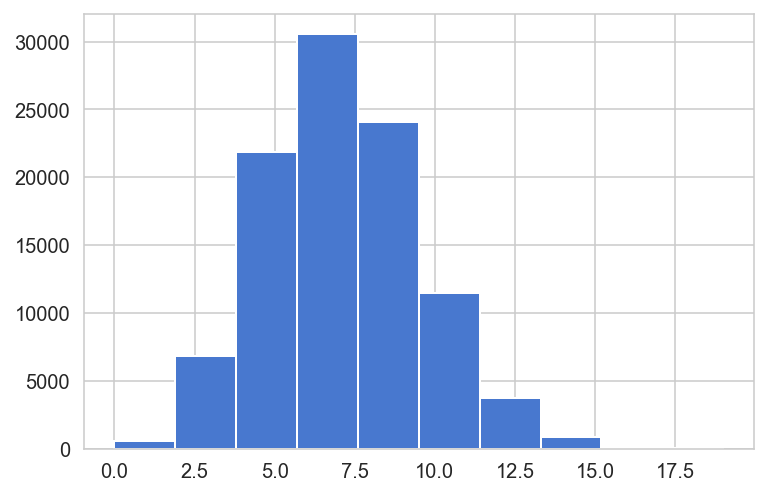

In [4]:
data = sim_data(sample_size, p_success, iterations)
f = plt.hist(data, edgecolor = 'white')

In [5]:
p_cured = sum(data)/len(data)
print('The probability of a patient getting cured is {}'.format(p_cured))

The probability of a patient getting cured is 7.00268


## A Problem: 
To get more visitors to your website, you are considering playing for an ad to be shown 100 times on Facebook. What experiment would you do to determine if this is a cost effective means of increasing your business?

### Basic Priors: How many ads will get clicked if ads get clicked 10% of the time.
- Joint probability distribution of porportion_clicks and n_visitors

In [6]:
iterations = 100000
ads = 100
click_rate = 0.1

In [7]:
data = sim_data (ads, click_rate, iterations)

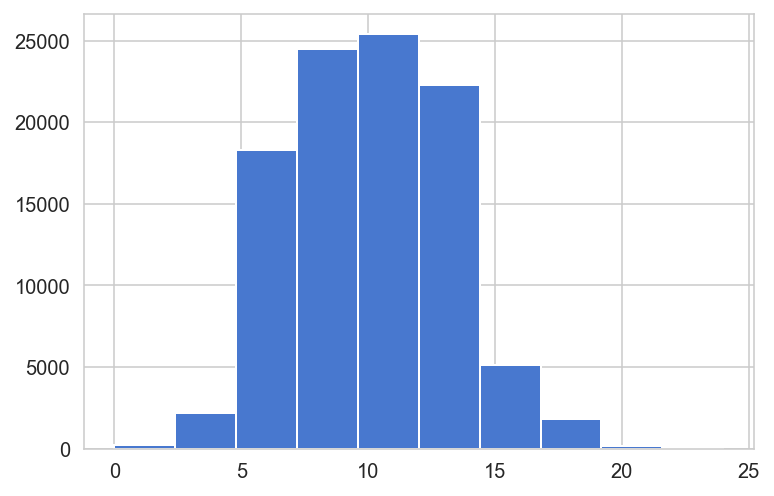

In [8]:
f = plt.hist(data)
# X = n_ads
# Y = Frequency of clicking on an add

You would like the ad campaign to result in at least 5 visitors to your site. Eyeballing the histogram, what is the probability you will get 5 or more visitors because of the ad?

90%

We know the average probability of a user clicking an ad, but quality of ad and placement are also factors, so we should assume variance due to these other contributing factors. Some of this additional uncertainty can be used in a Bayesian model, but not a frequentist model.

### Realistic Priors: Make the proportion of clicks a range of values between 0 and 2 * click rate 

In [9]:
def sim_data_range (s, p, i):
    """Binomial generative model that takes in a sample size (s),
    a number of iterations (i), and the expected success 
    rate (p), and returns a simulated 
    dataset of n size representing the success rate."""
    proportion_clicks = []
    data = []
    for i in range(iterations):
        # Slow to do this in a loop, but I need to plot the proportion clicks 
        # For a real run, get rid of proportion_clicks and replace it with 
        # the function call to np.random.uniform()
        proportion_clicks.append(np.random.uniform(low=0.0, high = 2*p, size=1))
        data.append(np.random.binomial(s, proportion_clicks[i], 1)[0])
    return proportion_clicks, data

In [10]:
proportion_clicks, n_visitors = sim_data_range(ads, click_rate, iterations)

#### Visualize Marginal distributions

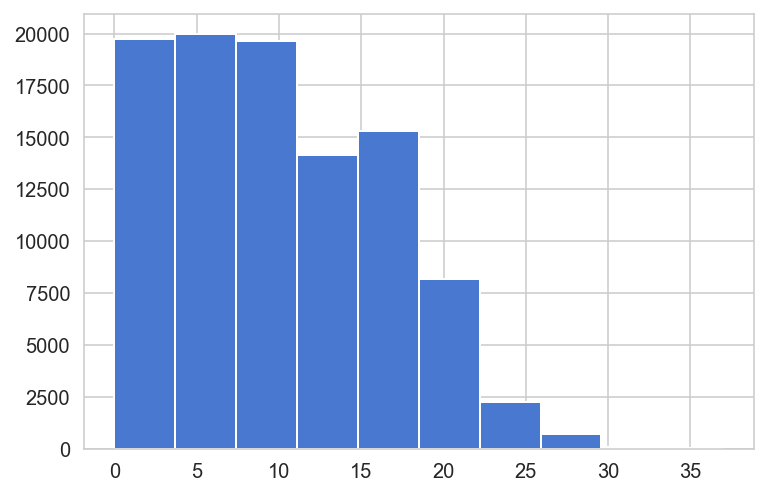

In [11]:
f = plt.hist(n_visitors)

### Priors --> Conditions (A given B)  --> Posteriors
- Limit the uncertainty by defining a condition of which there is a known probability distribution

#### Visualize Joint distribution of n_visitors and proportion_clicks (Priors)
- When you condition on clicks, only proportion of 10%, then reduce uncertainity
- When condition on visitors, reduce the uncertainty of what the underlying proportion of clicks could be

Text(0, 0.5, 'proportion_clicks')

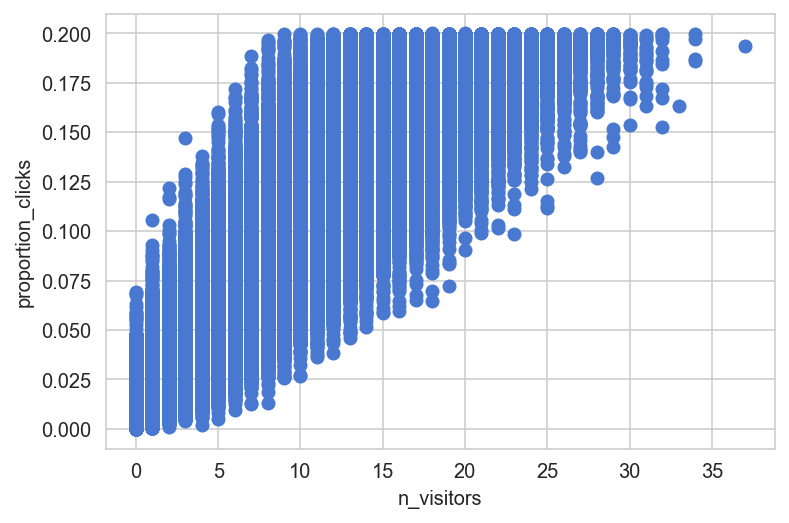

In [12]:
plt.scatter(n_visitors, proportion_clicks)
plt.xlabel('n_visitors')
plt.ylabel('proportion_clicks')

#### Condition on n_visitors = 5 ( what is probability of click given n_visitors = 5)

In [13]:
import pandas as pd
df = pd.DataFrame()
df['visitors'] = n_visitors
df['clicks'] = [p[0] for p in proportion_clicks]
df.head()

,visitors,clicks
0,17,0.187956
1,12,0.137936
2,21,0.153891
3,13,0.089458
4,2,0.034301


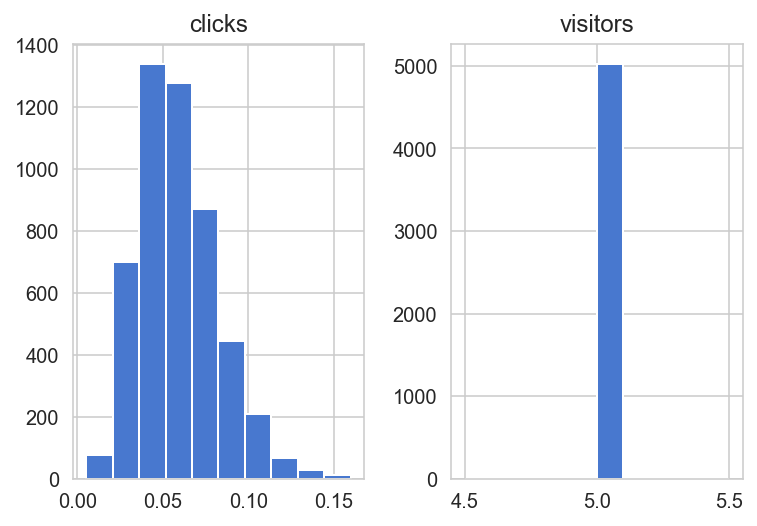

In [14]:
f = df[df.visitors == 5].hist()

#### Condition on visitors = 10 (What is probability of ad click given Visitors - 10)

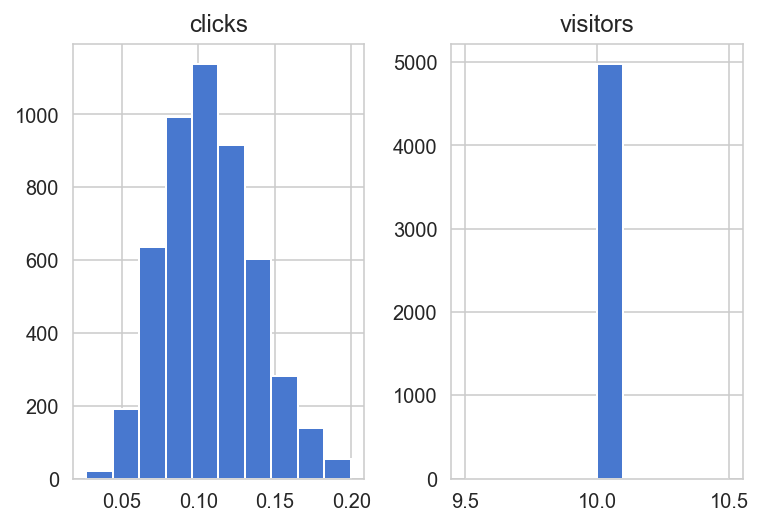

In [15]:
f = df[df.visitors == 10].hist()

#### Condition on visitors = 5 (What is the probability of clicks given n_visitors = 5)

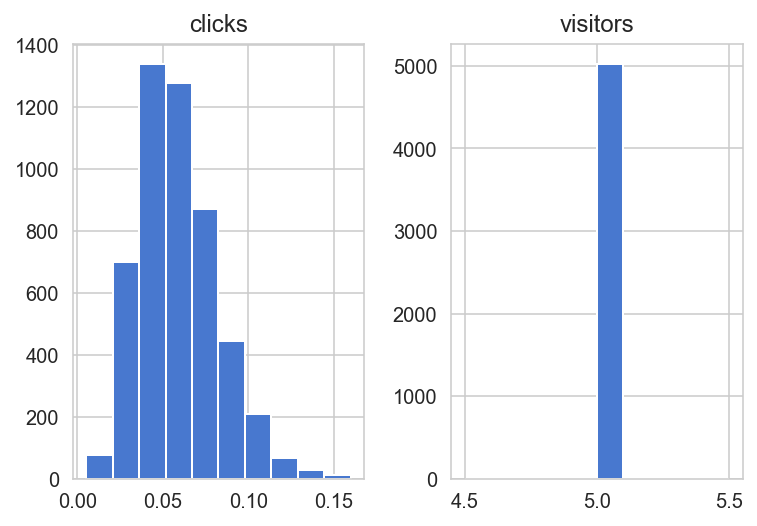

In [16]:
posteriors = df[df.visitors == 5].copy() 
f = posteriors.hist()

#### Example of generating "new" data based off of this first run
- Take the posteriors here for n_visitors = 18
- Plug those back into sim_data_range in place of the 0-2*click rate
- Calculate new marginal and joint distributions

In [17]:
def sim_data_post (s, p, i):
    """Binomial generative model that takes in a sample size (s),
    a number of iterations (i), and the expected success 
    rate (p), and returns a simulated 
    dataset of n size representing the success rate."""
    proportion_clicks = []
    data = []
    i = 0
    while i < iterations:
        # Slow to do this in a loop, but I need to plot the proportion clicks 
        # For a real run, get rid of proportion_clicks and replace it with 
        # the function call to np.random.uniform()
        for j in p:
            proportion_clicks.append(np.random.uniform(low=0.0, high = 2*j, size=1))
            data.append(np.random.binomial(s, proportion_clicks[i], 1)[0])
            i += 1
    return proportion_clicks, data

In [18]:
iterations = len(posteriors.clicks)
proportion_clicks, new_posteriors = sim_data_post(ads, posteriors.clicks, iterations)

In [19]:
posteriors['new_visitors'] = new_posteriors
posteriors.head()

,visitors,clicks,new_visitors
7,5,0.052521,6
16,5,0.092634,14
21,5,0.055003,1
22,5,0.015837,1
39,5,0.065467,9


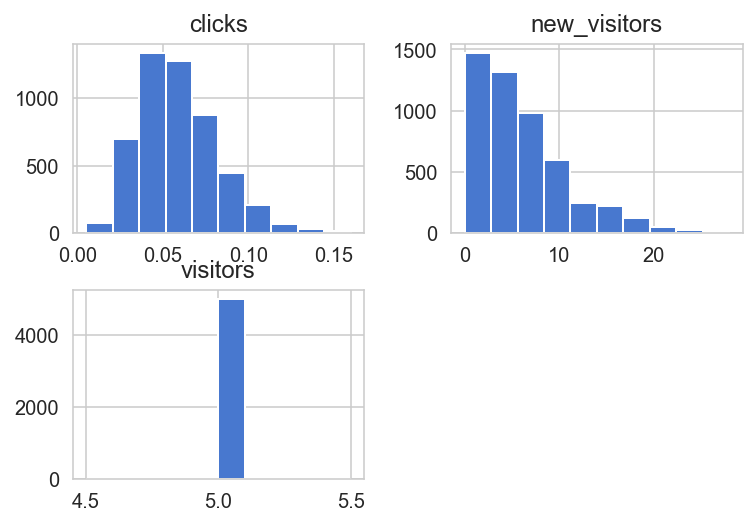

In [20]:
f = posteriors.hist()

#### Compare whether new data generated with posteriors is better than the original calculated with 0-20% * click_rate

In [21]:
new = sum(posteriors.new_visitors)/len(df.index) # In relation to the entire original sample size
old = sum(posteriors.visitors)/len(df.index)     # In relation to the entire original sample size

print('The old probability of clicks given a sample size of 5 is {}'.format(new))
print('The new probability of clicks given a sample size of 5 is {}'.format(old))

The old probability of clicks given a sample size of 5 is 0.29311
The new probability of clicks given a sample size of 5 is 0.2509


#### Probability of proportion of clicks

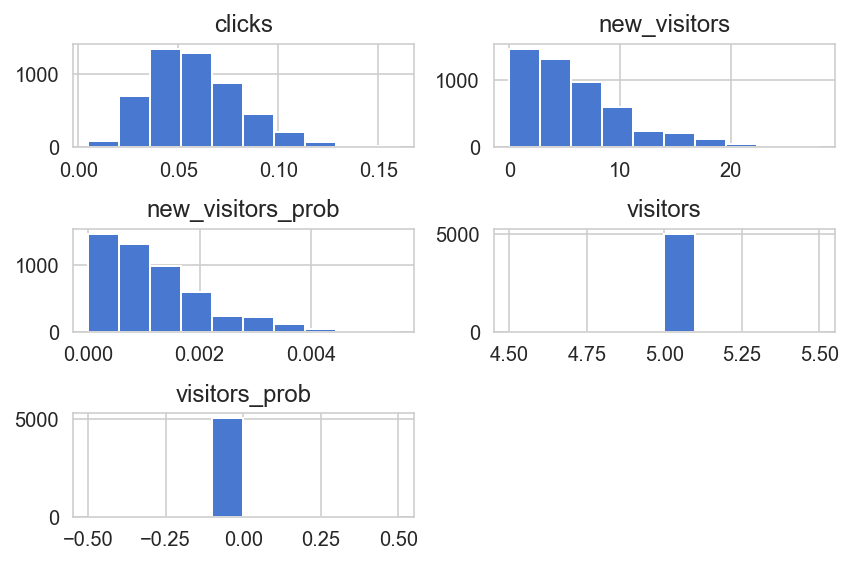

In [22]:
posteriors['visitors_prob'] = posteriors.visitors/len(posteriors.index)
posteriors['new_visitors_prob'] = posteriors.new_visitors/len(posteriors.index)
posteriors.hist()
plt.tight_layout()

### Informed Priors

- Prior distributions as the Beta distribution over proportions
- Have to know the range of probabilities (and ideally the mean)

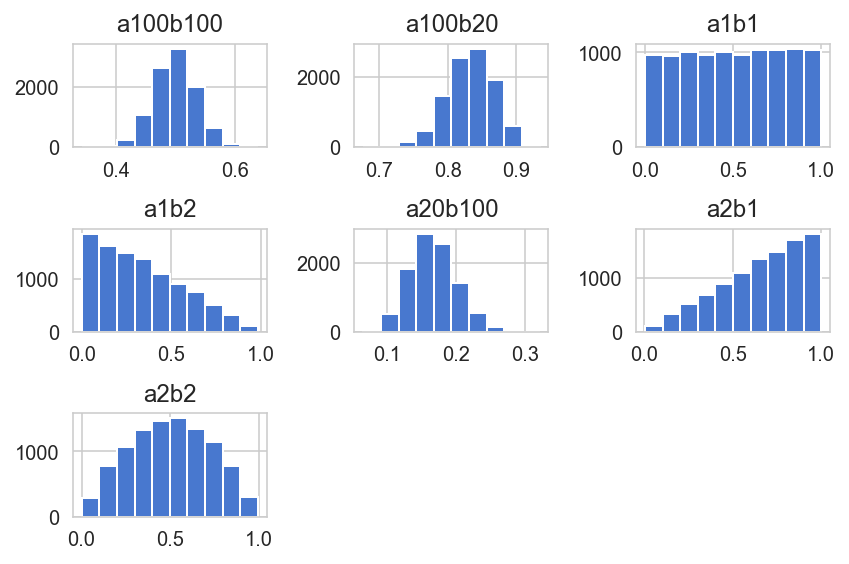

In [23]:
df = pd.DataFrame()

# Generator requires a class
# Generator.beta(a, b, size=None)
# Beta function is a special case of the Dirichlet distribution
Generator = np.random.default_rng()

df['a1b1'] = Generator.beta(1, 1, size=100*100)
df['a1b2'] = Generator.beta(1, 2, size=100*100)
df['a2b1'] = Generator.beta(2, 1, size=100*100)
df['a2b2'] = Generator.beta(2, 2, size=100*100)
df['a100b100'] = Generator.beta(100,100, size = 100*100)
df['a20b100'] = Generator.beta(20,100, size = 100*100)
df['a100b20'] = Generator.beta(100,20, size = 100*100)

f = df.hist()
plt.tight_layout()

- The larger a and b are, the more concentrated the distribution becomes
- The greater the difference between a & b the more skewed the set
    - Smaller A == mean closer to 0
    - Smaller B = mean closer to 1
    

#### Hand-picking an appropriate a and b
- For the problem at hand, click through averages 5% with a min of 2% and max of 8%
- This is very right skewed with the data heavily centered to the left
- Minimize A and Maximize B

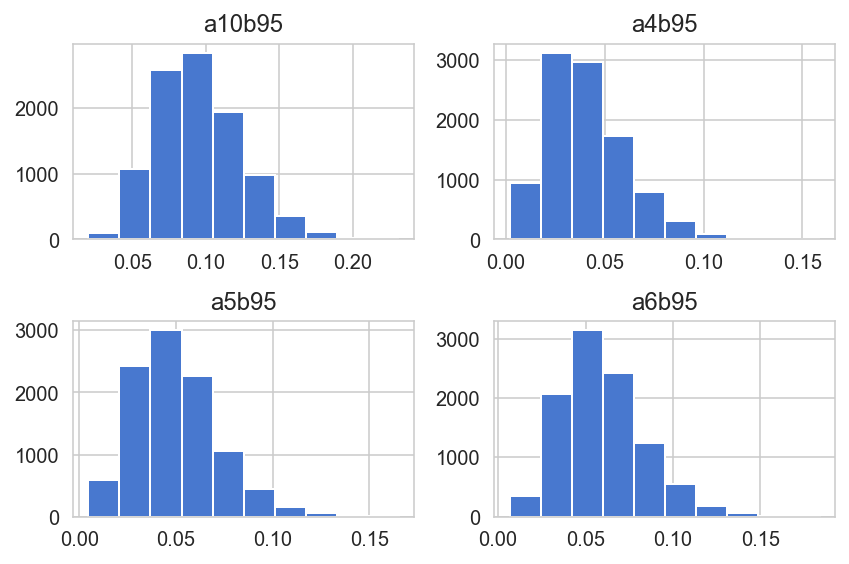

In [24]:
df2 = pd.DataFrame()
df2['a5b95'] = Generator.beta(5,95, size = 100*100)
df2['a6b95'] = Generator.beta(6,95, size = 100*100)
df2['a10b95'] = Generator.beta(10,95, size = 100*100)
df2['a4b95'] = Generator.beta(4,95, size = 100*100)
df2.hist()
plt.tight_layout()

- Choose A = 5 and B = 95 because center is at 0.05 with a range between 0 and 0.12 and most of the probabilities between 2 and 8

#### Compare original proportion_clicks to the informed beta distribution

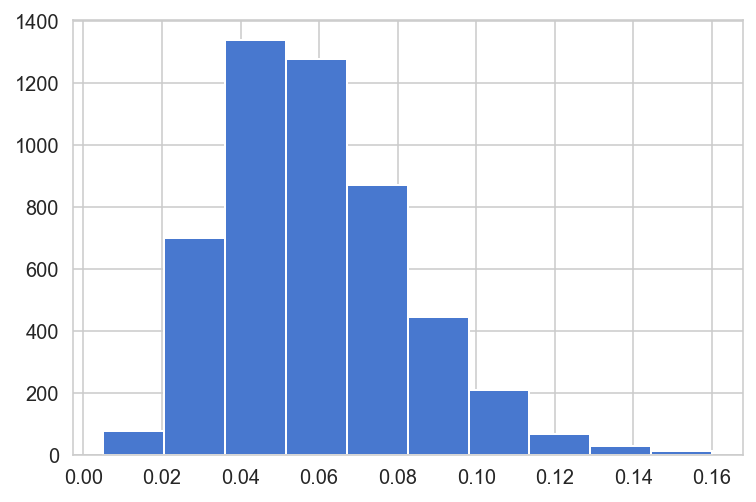

In [25]:
f = posteriors.clicks.hist() # Orig with 0-20% range guessed

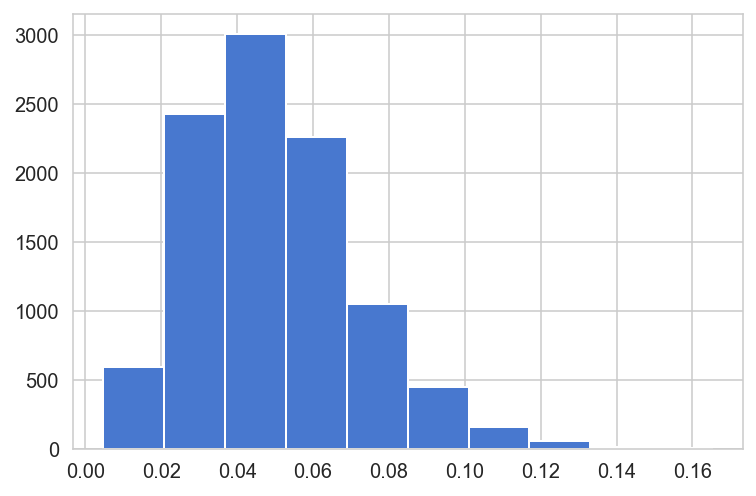

In [26]:
f = df2['a5b95'].hist() # Informed Beta range with 2-8%

- If you have no data, then only the prior would be known
- If you have a ton of data, then the information in the data would overwhelm the priors and outcome would be fairly independent of priors (a la frequentist)

# Bayesian Inference to make comparisons between groups

#### Problem: 
You have been using video ads but now want to try text ads. You get 13/100 clicks on the videos but only 6/100 on the text. Seems like video ads work better, but how sure are you?

#### Approache #1:
Run the same model on the data from the video and the text ads and compare the corresponding posteriors over the underlying proportions of clicks
  - Wind up with 2 distributions, one for each
  - Need to get a new probability distribution showing the probable difference
  - Make a dataframe with the video proportions and the text proportions
  - Add a column with df.vid - df.txt
  - Make histogram of resulting probabilities
    

#### Remake the overall click rate distributions using the old-school non-beta method

In [27]:
iterations = 100000
n_ads = 100
click_rate = 0.1

In [28]:
overall_clicks, overall_visitors = sim_data_range(n_ads, click_rate, iterations)

In [29]:
df3 = pd.DataFrame()
df3['overall_visitors'] = overall_visitors
df3['overall_clicks'] = [c[0] for c in overall_clicks]
df3.head()

,overall_visitors,overall_clicks
0,15,0.121220
1,11,0.114077
2,2,0.015146
3,12,0.161054
4,12,0.102666


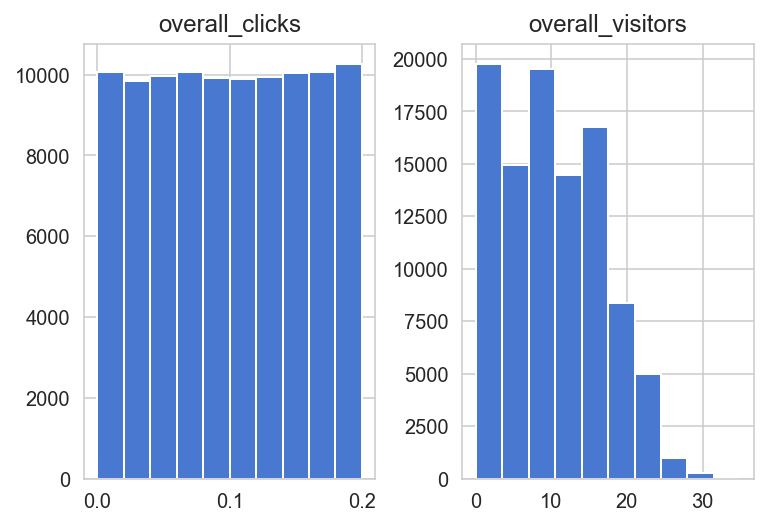

In [30]:
f = df3.hist()

#### Get posteriors for video (13/100)

In [31]:
vid_post = df3[df3.overall_visitors == 13]

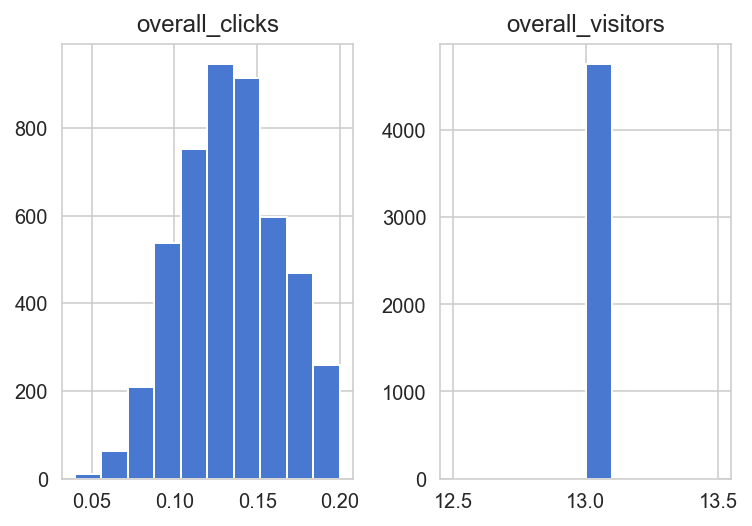

In [32]:
f = vid_post.hist()

#### Get posteriors for text ads (6/100)

In [33]:
txt_post = df3[df3.overall_visitors == 6]

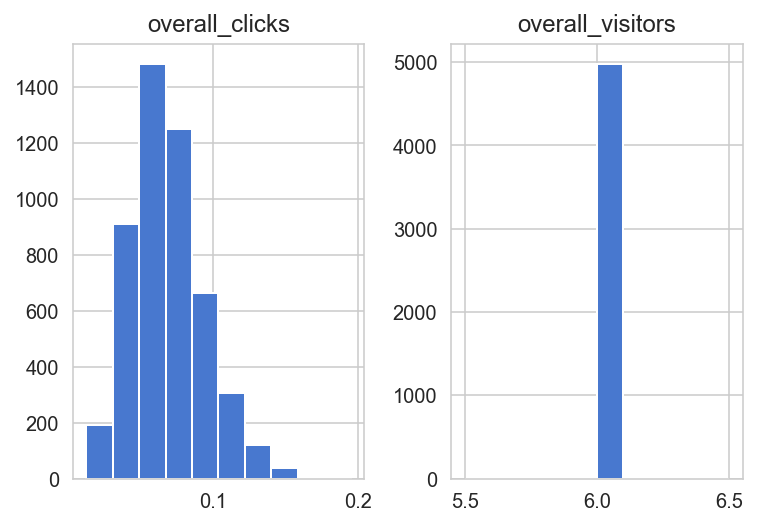

In [34]:
f = txt_post.hist()

#### Calculate the difference in posterior probability distribution of clicks

In [35]:
min_len = min(len(vid_post),len(txt_post))
min_len

4753

In [36]:
df4 = pd.DataFrame()
df4['vid_post'] = [v for v in vid_post.overall_clicks[:min_len].values]
df4['txt_post'] = [v for v in txt_post.overall_clicks[:min_len].values]
df4['difference'] = df4.vid_post - df4.txt_post
df4.head()

,vid_post,txt_post,difference
0,0.170797,0.080404,0.090393
1,0.167419,0.038505,0.128914
2,0.131073,0.044317,0.086756
3,0.169617,0.051271,0.118346
4,0.129795,0.068324,0.061472


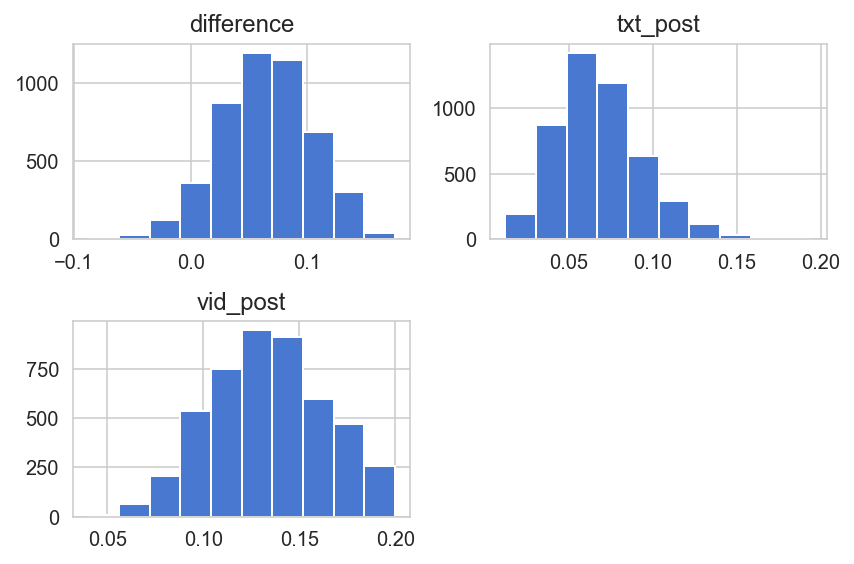

In [37]:
f = df4.hist()
plt.tight_layout()

#### Point Estimate: Most likely difference between video_proportion and text_proportion

In [38]:
np.median(df4.difference)

0.06543931106360663

#### Calculate the probability that the proportion of clicks is larger for the video ad than the text ad
- Already working in proportions so it will be the proportion of samples in df4.difference > 0

In [39]:
prob_vid_over_txt =df4.difference[df4.difference > 0].count()/len(df4.index)
prob_vid_over_txt

0.9492951819903219

# Bayesian Analysis to do Decision Analysis
#### Which type of ad will net the most money

In [40]:
vid_cost = 0.25 # Cost per ad
txt_cost = 0.25 # Cost per ad
visitor_spend = 2.53 # Historical data (priors)

#### Calculate profit per sample

In [41]:
df4['vid_profit'] = df4.vid_post * visitor_spend - vid_cost
df4['txt_profit'] = df4.txt_post * visitor_spend - txt_cost
df4['profit_diff'] = df4.vid_profit - df4.txt_profit
df4.head()

,vid_post,txt_post,difference,vid_profit,txt_profit,profit_diff
0,0.170797,0.080404,0.090393,0.182116,-0.046579,0.228695
1,0.167419,0.038505,0.128914,0.173570,-0.152582,0.326152
2,0.131073,0.044317,0.086756,0.081614,-0.137878,0.219492
3,0.169617,0.051271,0.118346,0.179131,-0.120285,0.299416
4,0.129795,0.068324,0.061472,0.078383,-0.077141,0.155523


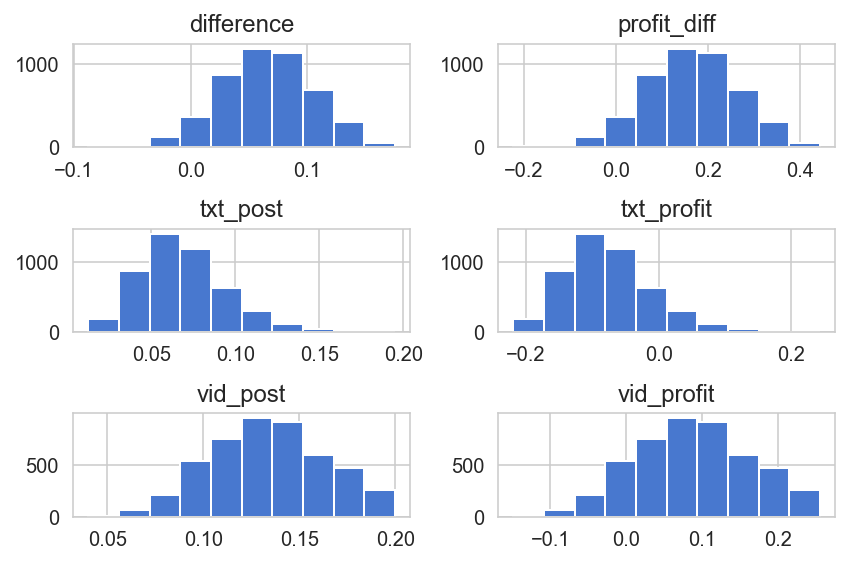

In [42]:
f = df4.hist()
plt.tight_layout()

#### Point estimate for Video vs text profit

In [43]:
np.median(df4.profit_diff)

0.16556145699092478

#### How much more profitable is the video vs the txt ads

In [44]:
best = np.mean(df4.profit_diff[df4.profit_diff > 0])
print('You will make {}% with the video ads compared to txt ads'.format(round(best*100,2)))

You will make 17.59% with the video ads compared to txt ads


- Of note, look at the distribution. What is the 90% Confidence interval?
- If the spread is wide, you can't be very certain and should get more data before making a decision
- Test this with a t-test or z-test depending on your sample size

# Working with other statistical models (besides binomial)

#### Problem: 
- A banner ad paid per day rather than by view
- Previous trial got 19 clicks/day
- How many daily site visits should we expect on average if we pay for this banner

#### Solution
- Use a poisson distribution to break that 1 day up into an infinite probability distribution
- Takes one parameter, the number of clicks per day


In [45]:
def sim_poisson(click_rate, iterations):
    """Takes a click rate and generates a poisson distribution"""

    proportion_clicks = []
    data = []
    i = 0
    while i < iterations:
        # If/else used to provide variance in the random data.
        if i % 2 == 0:
            proportion_clicks.append(np.mean(Generator.uniform(low=0, \
                                    high = 2*click_rate-10, size=10)) \
                                    + np.random.randint(10))
        else:
            proportion_clicks.append(np.median(Generator.uniform(low=10, \
                                    high = 2*click_rate, size=10) \
                                    - np.random.randint(10)))
            
        data.append(Generator.poisson(proportion_clicks[i], 1)[0])
        i += 1
    return data, proportion_clicks

In [46]:
n_visitors, prior_clicks = sim_poisson(19, 100000)

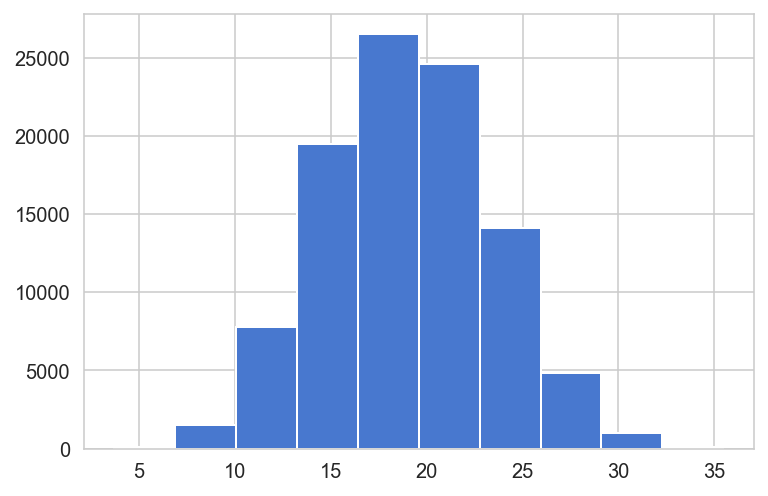

In [47]:
f = plt.hist(prior_clicks)

In [48]:
df5 = pd.DataFrame()
df5['n_visitors'] = n_visitors
df5['prior_clicks'] = prior_clicks
df5.head()

,n_visitors,prior_clicks
0,14,18.967253
1,22,19.180721
2,17,15.136632
3,19,20.666518
4,30,27.357379


In [49]:
posterior_clicks = df5.prior_clicks[df5.n_visitors == 19]

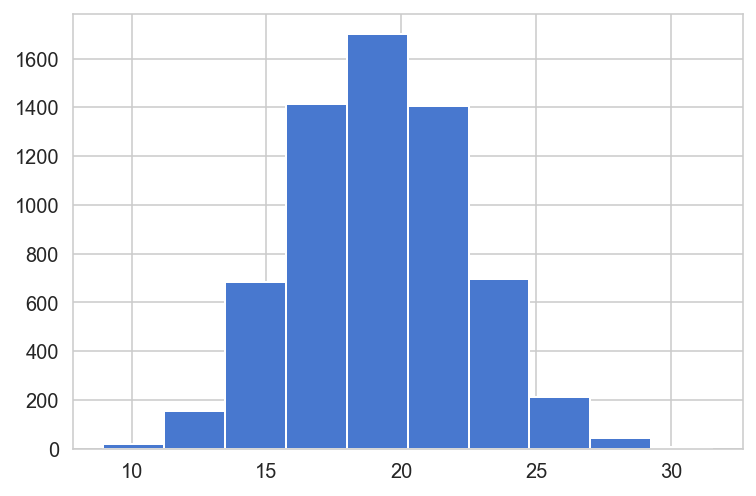

In [50]:
f = plt.hist(posterior_clicks)

# Probability Theory in Action

#### Problem
What is the probability of n_visitors = 13 or _visitors = 14 given the probability of success = 10%

In [55]:
visitors, clicks = sim_poisson(10, 100000)

(array([  767.,  6920., 14299., 16761., 17077., 16900., 16028.,  8786.,
         2274.,   188.]),
 array([ 2.05058528,  3.75796394,  5.46534261,  7.17272128,  8.88009994,
        10.58747861, 12.29485728, 14.00223594, 15.70961461, 17.41699328,
        19.12437194]),
 <a list of 10 Patch objects>)

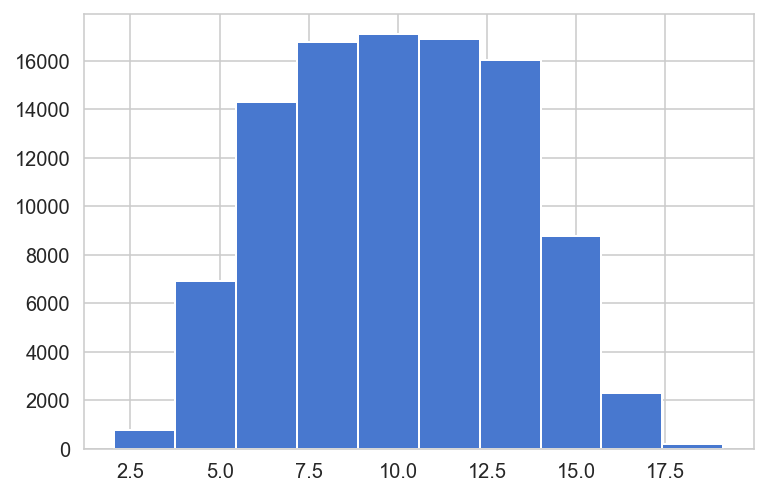

In [56]:
plt.hist(clicks)

In [57]:
df6 = pd.DataFrame ()
df6['visitors'] = visitors
df6['clicks'] = clicks
df6.head()

,visitors,clicks
0,16,11.113530
1,8,11.584029
2,10,10.882639
3,10,8.309067
4,13,15.458855


In [63]:
post13 = df6.clicks[df6.visitors == 13]
post14 = df6.clicks[df6.visitors == 14]